<a href="https://colab.research.google.com/github/GreggHeller1/dendritic_distance/blob/main/scripts/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#settings
%load_ext autoreload
%autoreload 2
try:
  import google.colab
  in_colab = True
except:
  in_colab = False
print(in_colab)

False


In [8]:
#installs (for colab only, run this once)
if in_colab:
    ! git clone https://github.com/GreggHeller1/dendritic_distance.git


In [10]:
#local imports
#cwd if in colab for imports to work
if in_colab:
    %cd /content/dendritic_distance
    
from src import helper_functions as hf
from src import config as cfg
from src import data_io as io


In [11]:
#imports

from matplotlib import pyplot as plt
import os
import numpy as np

In [12]:
#define paths
#cwd if in colab for file loading to work
if in_colab:
    %cd /content/Neuron_Tutorial/scripts
    
test_path = os.path.join('demo_data', 'test.txt')
print(test_path)
print(os.getcwd())
os.path.exists(test_path)

demo_data/test.txt
/Users/Gregg/code/dendritic_distance


True

In [13]:
#data inputs
io.readfile(test_path)


Reading file at demo_data/test.txt
Testing whether we can read the contents of a text file in colab

maybe we need another line?


# Dendritic Distance

This notebook is intended to demonstrate the functionality of the dendritic distance repository - computing the distance between pairs of spines captured in a single field of view for different types of distance - both dednritic path ffollowing distance, and euclidian "as the crow flies" distance." It is currently intended for planar images, but could be adapted to Z stacks and distance in 3d space in the future. 



# You can also use this colab notebook to test the code on your own images and ROIs by adding a new folder to demo_data that contains the 3 required files with appropriate names

In [28]:
def main(kyle_rois, projection_tif, shaft_roi):
    
    spine_rois, dend_rois, other_rois = io.seperate_kyle_rois(kyle_rois)
    all_segments, branch_points = hf.initialize_dendrite(shaft_roi)

    spines = []
    sanity_checks = {}
    for spine_roi, dend_roi in zip(spine_rois, dend_rois):
        this_spine = hf.Spine(spine_roi, dend_roi, all_segments)
        spines.append(this_spine)
        for sanity_check, value in this_spine.sanity_checks.items():
            if not (sanity_check in sanity_checks):
                sanity_checks[sanity_check] = []
            sanity_checks[sanity_check].append(value)

    spine_dmats = hf.euclidian_dmats(spines)
    dend_d_mat, b_mat = hf.dendritic_distance_matrix(spines)
    spine_dmats["dendritic_distance"] = dend_d_mat
    spine_dmats["seperated_by_branch_point"] = b_mat.astype(int)
    
    return spines, all_segments, spine_dmats, sanity_checks
    

In [1]:


# First lets take a look at the 3 necessary files
#Load and plot all the files

path_list = [os.path.join('demo_data', dirname) for dirname in os.listdir('demo_data')]
dir_list = [fullpath for fullpath in path_list if os.path.isdir(fullpath)]

fig, axs = plt.subplots(len(dir_list), 4, figsize=(len(dir_list)*4, 4*2))

for i, current_data_dir in enumerate(dir_list):
    kyle_rois, projection_tif, shaft_roi = io.load_all(current_data_dir)
    spines, all_segments, spine_dmats, sanity_checks = main(
                                                            kyle_rois, 
                                                            projection_tif, 
                                                            shaft_roi)
    #plot the average projection tif
    io.projection_tif(projection_tif, axs[i,0])
    
    #plot the spine ROIs
    io.plot_kyle_rois(kyle_rois, ax=axs[i,1], legend=True, invert=True)
    
    #plot the dendrite ROIs
    io.plot_dendrite_rois(shaft_roi, ax=axs[i,2], legend=True, invert=True)
    
    #plot the overlay
    io.projection_tif(projection_tif, axs[i,3])
    io.plot_kyle_rois(kyle_rois, ax=axs[i,3])
    io.plot_dendrite_rois(shaft_roi, ax=axs[i,3])
    


NameError: name 'os' is not defined

IndexError: list index out of range

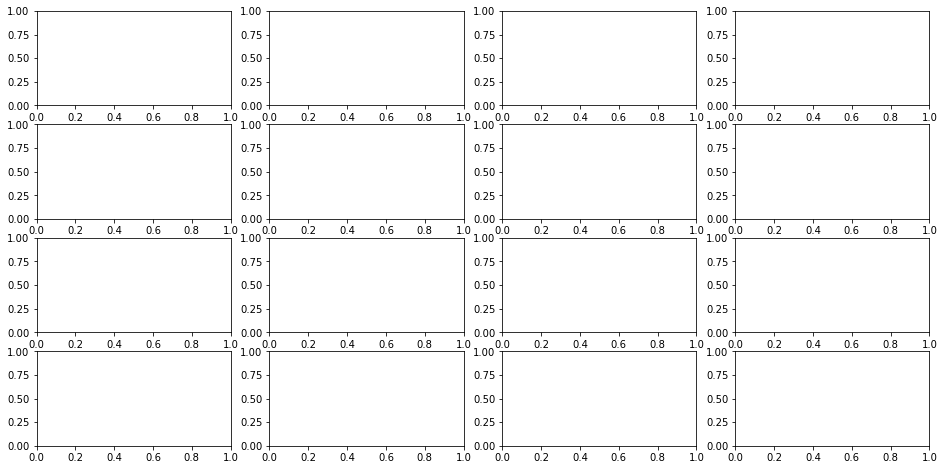

In [33]:

# Next lets look at the distance computations
#TODO Make sure the two dmats are on the same color scale

#TODO should also label the spines by number here - may have to do a scatter? willbe easier to look this up
fig, axs = plt.subplots(len(dir_list), 4, figsize=(len(dir_list)*4, 4*2))

for i, current_data_dir in enumerate(dir_list):
    kyle_rois, projection_tif, shaft_roi = io.load_all(current_data_dir)
    spines, all_segments, spine_dmats, sanity_checks = main(
                                                            kyle_rois, 
                                                            projection_tif, 
                                                            shaft_roi)
    #plot the cleaner overlay image
    ax = axs[i,0]
    io.projection_tif(projection_tif, ax)
    io.plot_dendrite(all_segments, ax)
    io.plot_spines(spines, ax)

    #plot weather the connection is through a branch point
    axs[i,1].imshow(spine_dmats['seperated_by_branch_point'])
    axs[i,1].set_title('Seperated by branch point')
    
    den_ds = spine_dmats['dendritic_distance']
    combined_data = np.array([den_ds,
                             spine_dmats['euclidian distance between Spine Centers']]
                             )
    combined_data= combined_data.astype(np.float64)
    #Get the min and max of all your data
    _min, _max = np.nanmin(combined_data), np.nanmax(combined_data)

    #plot the dendritic distances
    
    print(_max)
    print(_min)
    den_ds[np.isnan(den_ds)] = _max
    axs[i,2].imshow(den_ds, cmap=plt.cm.copper, vmin = _min, vmax = 2*_max)
    axs[i,2].set_title('Dendritic distances')
    

    
    #plot the euclidean distances
    axs[i,3].imshow(spine_dmats['euclidian distance between Spine Centers'], cmap=plt.cm.copper, vmin = _min, vmax = 2*_max)
    axs[i,3].set_title('Euclidean distance between spine centers')




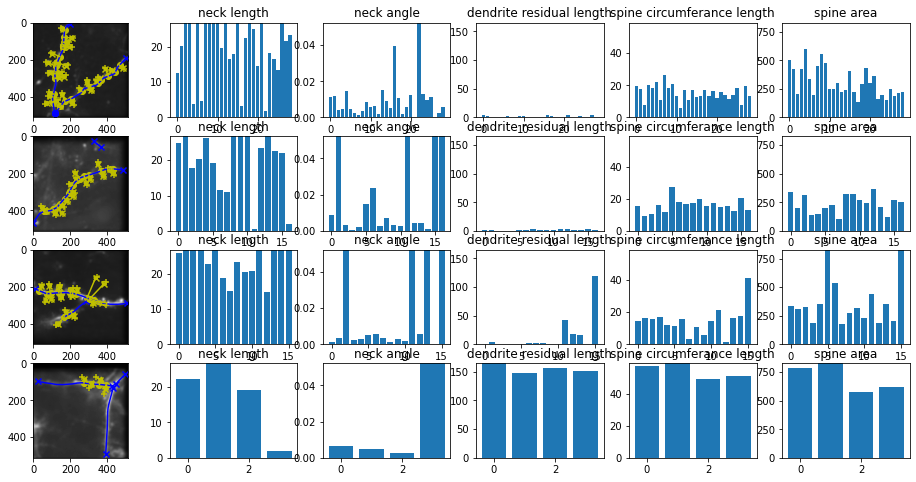

In [ ]:
#Last lets look at the spine stats and how they can be used for QC
# label each of them with a number, and then use the number to plot the value as a bar
# neck angle, neck length, area, circumference and dend residual

fig, axs = plt.subplots(len(dir_list), len(sanity_checks.keys())+1, figsize=(len(dir_list)*4, 4*2))

maxes = [0]*len(sanity_checks)
for i, current_data_dir in enumerate(dir_list):
    kyle_rois, projection_tif, shaft_roi = io.load_all(current_data_dir)
    spines, all_segments, spine_dmats, sanity_checks = main(
                                                            kyle_rois, 
                                                            projection_tif, 
                                                            shaft_roi)
    #plot the cleaner overlay image
    ax = axs[i,0]
    io.projection_tif(projection_tif, ax)
    io.plot_dendrite(all_segments, ax)
    io.plot_spines(spines, ax)

    #plot each of the sanity checks
    for j, (key, values) in enumerate(sanity_checks.items()):
        ax = axs[i,j+1]
        ax.bar(list(range(len(values))), values)
        ax.set_title(key)
        maxes[j] = max((maxes[j], max(values)))

for i, current_data_dir in enumerate(dir_list):
    for j, check_max in enumerate(maxes):
        axs[i,j+1].set_ylim([0,check_max])



In [13]:
#Maybe add one more to demo the different types of euclidean measurements
#Also maybe add a zoom in on the erroneous one - number the spines so you can speak about them and the errors 

d = {'a':4, 'b':5, 'c':2}

def sort_by_value(pair):
    return pair[1]


print(sorted(d.items(), key=sort_by_value, reverse=True))


[('b', 5), ('a', 4), ('c', 2)]
